# Python Interface
On of the core strength of [pyiron](https://pyiron.org) is the one to one mapping between the visual programming interface and the underlying Python framework. This enables collaborators with different preferences to work seamlessly together, as the same workflow can be edited from the Python interface or the visual programming interface. 

## Young's Modulus 
To demonstrate this functionality we take the same Young's Modulus example from the previous tutorial but this time rather than creating the workflow visually, we first create and evaluate it from Python before transferring it to the visual programming interface. 

Again, as a reminder in Jupyter notebooks the individual cells are evaluated by pressing **Shift** and **Enter**. 

Start by creating a workflow named `YoungsModulusPython` using the `Workflow` class from the `pyiron_core` module:

In [1]:
import pyiron_core

In [2]:
wf = pyiron_core.Workflow("YoungsModulusPython")

After the workflow is create the next step is adding the corresponding workflow nodes. These nodes are available in the `pyiron_nodes` module which is located in the `~/pyiron_nodes` folder in the home directory of the user to allow the user to modify and extend their `pyiron_nodes`. In analogy to the visual programming example four nodes are imported: 
* The **ReadCSV** node from the `pyiron_nodes.basic.file` module.
* The **ConvertLoadToStress** node from the `pyiron_nodes.experiment.youngs_modulus` module.
* The **CalculateYoungsModulus** node again from the `pyiron_nodes.experiment.youngs_modulus` module.
* Finally, the **Plot** node again from the `pyiron_nodes.experiment.youngs_modulus` module. 

In [3]:
from pyiron_nodes.basic.file import ReadCSV
from pyiron_nodes.experiment.youngs_modulus import ConvertLoadToStress, CalculateYoungsModulus, Plot

The node functions can be handled similar to regular Python functions, with the major difference that the outputs of these Python functions have to be assigned to workflow objects. In analogy, to the visual programming construction of the Young's modulus the **ReadCSV** node can be renamed by assigning it to `wf.ReadDataset`. In this case `wf.ReadDataset` is the new node created in the workflow graph. 

In [4]:
wf.ReadDataset = ReadCSV(filename="data/dataset_1.csv")

It is important to node that nodes cannot be overwritten. When the same line is executed again `pyiron_core` complains and returns a `ValueError: Node with label ... already exists` error. This can be addressed by restarting the construction of the workflow. So typically all the commands to create a workflow are written in one Jupyter notebook cell.

In [5]:
wf = pyiron_core.Workflow("YoungsModulusPython")
wf.ReadDataset = ReadCSV(filename="data/dataset_1.csv")
wf.ConvertLoadToStress = ConvertLoadToStress(df=wf.ReadDataset, area=120)
wf.CalculateYoungsModulus = CalculateYoungsModulus(
    stress=wf.ConvertLoadToStress.outputs.stress, 
    strain=wf.ConvertLoadToStress.outputs.strain,
)
wf.Plot = Plot(
    stress=wf.ConvertLoadToStress.outputs.stress, 
    strain=wf.ConvertLoadToStress.outputs.strain,
)

As the **ReadCSV** node produces only a single output the `pandas` Dataframe named `csv` it is sufficient to provide the whole node, in this case **wf.ReadDataset** as an input to the **df** parameter of the **ConvertLoadToStress** node. For nodes which return multiple outputs, the individual outputs can be selected with the extension `outputs` followed by the name of the output. So to transfer the `stress` and `strain` from the **ConvertLoadToStress** node to the **CalculateYoungsModulus** node and **Plot** node, you can use: `wf.ConvertLoadToStress.outputs.stress` and `wf.ConvertLoadToStress.outputs.strain` correspondingly. 

To evaluate a given node call `pull()` for this node. For example the **CalculateYoungsModulus** node is evaluated using `wf.CalculateYoungsModulus.pull()`. Only at this point the execution of the workflow is triggered, the CSV file is loaded, the load is converted to stress and strain and afterwards those are used as inputs to calculate the Young's Modulus.

In [6]:
wf.CalculateYoungsModulus.pull()

175.18008476297007

In the same way the stress strain curve can be visualized by calling `pull()` on the **Plot** node:

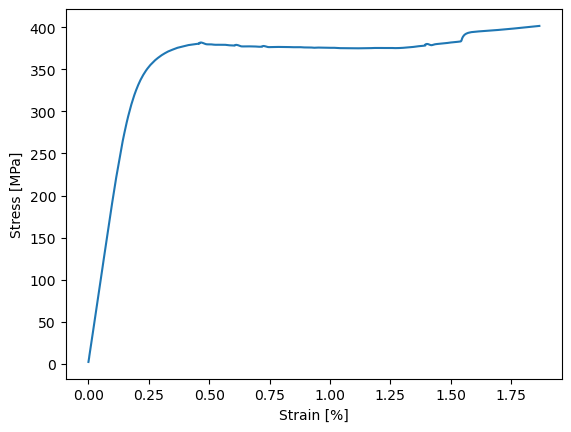

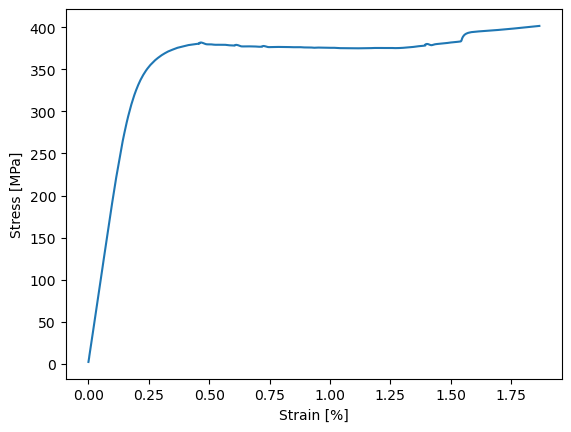

In [7]:
wf.Plot.pull()

Finally, the same workflow can be used in the visual programming interface, by providing the workflow and the `pyiron_nodes` directory as additional inputs. 
![Youngsmodulus](img/calculateYoungModulus.png)

In [8]:
pyiron_core.PyironFlow(wf_list=[wf], nodes_path="pyiron_nodes").gui

added node path:  /home/jovyan


The different workflows in the `wf_list` are loaded as different tabs. In case a workflow is not directly visible you can use the **Refresh** button in the top left menu of the canvas to refresh the visualization. Finally, to evaluate the workflow again you can click the **Run** button on the menu on top of the **Plot** node. Or alternatively, you can also evaluate one node at a time, which can be helpful for debugging. 

## Python Functions
On of the core features of the pyiron workflow framework is its extendability, in particular pyiron allows you to define nodes directly inside your Jupyter notebook to simplify rapid prototyping. Again staying with the example of the Youngs modulus we define the individual Python functions using the `@as_function_node` decorator.

Starting with the **ReadCSV** node to read the CSV file and convert it to a `pandas` DataFrame. By adding the parameter `"csv"` in the `as_function_node` decorator the output port of the **ReadCSV** node is named `csv`. 

In [9]:
@pyiron_core.as_function_node("csv")
def ReadCSV(filename: str, header: list = [0, 1], decimal: str = ",", delimiter: str = ";"):
    import pandas as pd
    return pd.read_csv(filename, delimiter=delimiter, header=header, decimal=decimal)

A separate naming of the output variables is commonly not necessary when only individual variables are returned. This is enabled by analysing the source code of the Python functions. For example in the **ConvertLoadToStress** the variables `stress` and `strain` are already defined internally and these are the only variables returned at the end of the function, consequently it is not necessary to provide any additional output name for the `as_function_node` decorator: 

In [10]:
@pyiron_core.as_function_node
def ConvertLoadToStress(df, area):
    """
    Read in csv file, convert load to stress
    """
    kN_to_N = 0.001  # convert kiloNewton to Newton
    mm2_to_m2 = 1e-6  # convert square millimeters to square meters
    df["Stress"] = df["Load"] * kN_to_N / (area * mm2_to_m2)
    #although it says extensometer elongation, the values are in percent! 
    strain = df["Extensometer elongation"].values.flatten()
    #subtract the offset from the dataset
    strain = strain - strain[0]
    stress = df["Stress"].values.flatten()
    return stress, strain

The stress and strain values, which are outputs of the **ConvertLoadToStress** node are used for a linear fit in the **CalculateYoungsModulus** node, and the Young's modulus is calculated as the slope of this linear fit. The calculated value of Young's modulus will depend on the `strain_cutoff` parameter. Internally, this function is using the `numpy` package for fitting. The import statement is included in the function body to minimize the risk of conflicts.

In [11]:
@pyiron_core.as_function_node
def CalculateYoungsModulus(stress, strain, strain_cutoff=0.2):
    import numpy as np
    percent_to_fraction = 100  # convert
    MPa_to_GPa = 1 / 1000  # convert MPa to GPa
    arg = np.argsort(np.abs(np.array(strain) - strain_cutoff))[0]
    fit = np.polyfit(strain[:arg], stress[:arg], 1)
    youngs_modulus = fit[0] * percent_to_fraction * MPa_to_GPa
    return youngs_modulus

Finally, the **Plot** node is defined, which internally uses the `matplotlib` library to create an xy-plot of the stress over strain curve.

In [12]:
@pyiron_core.as_function_node("fig")
def Plot(stress, strain, format="-"):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.plot(strain, stress, format)
    ax.set_xlabel("Strain [%]")
    ax.set_ylabel("Stress [MPa]")
    return fig

With these four functions the workflow can again be constructed in analogy to the previous section and the same workflow can also again be loaded in the visual programming interface to share it with users who prefer the visual programming interface.

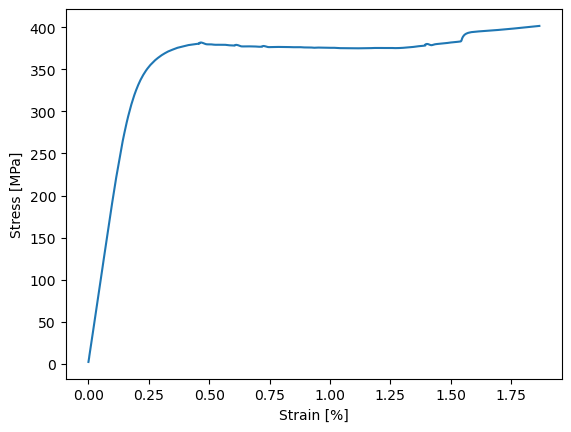

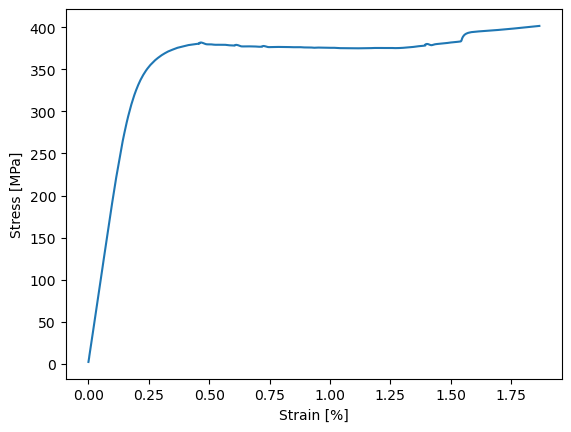

In [13]:
wf = pyiron_core.Workflow("YoungsModulusFunction")
wf.ReadDataset = ReadCSV(filename="data/dataset_1.csv")
wf.ConvertLoadToStress = ConvertLoadToStress(df=wf.ReadDataset, area=120)
wf.CalculateYoungsModulus = CalculateYoungsModulus(
    stress=wf.ConvertLoadToStress.outputs.stress, 
    strain=wf.ConvertLoadToStress.outputs.strain,
)
wf.Plot = Plot(
    stress=wf.ConvertLoadToStress.outputs.stress, 
    strain=wf.ConvertLoadToStress.outputs.strain,
)
wf.Plot.pull()

## From Functions to Modulus
If you use the file browser in jupyter lab and navigate to the `pyiron_nodes` folder and inside open the subfolder `experiment` and the Python file `youngs_modulus.py` then you see that the nodes we defined in the Jupyter notebook are exactly the same as the ones which are used in the **Node Library** of the visual programming interface. More specifically, you can simply add your own nodes to the local **Node Library** by using the `@as_function_node` decorator and placing them in the `pyiron_nodes` folder. 

For development purposes it might even be helpful to create a separate folder in the `pyiron_nodes` or a standalone nodes library for you project. All you have to do to load nodes from a different location on the file system is to change the `nodes_path` when you initialize the visual programming interface. This highlights the extendability of the [pyiron](https://pyiron.org) workflow framework. 